### We determine how to convert displacement sensor readings into M2 position
The data used here is the same as in a19_position_repeatability.ipynb

In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Multiple positions for +x
The start and end time below are obtained by looking at the corresponding plots in a19_position_repeatability.ipynb
* we want only one peak in position, which makes it easier to tell which sensor is making biggest move.
* we want to have the start time or end time to be at zero position. This makes it easy to subtract sensor offset.
* we also need to make sure the time period (start, end) falls into one binary file. otherwise we have to read into two files and join the arrays.

In [2]:
start = Time('2020-03-04T18:04:00') #this is UTC # we went to x=-500um and back
end = Time('2020-03-04T18:12:00') 

In [3]:
client = EfdClient('summit_efd')
csc_index = 1

In [4]:
df = await client.select_time_series('lsst.sal.MTM2.mirrorPositionMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
df.head()

,piston,private_host,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,thetaZPosition,xPosition,xTilt,yPosition,yTilt
2020-03-04 18:04:00.014000+00:00,-0.002429,1,1.583345e+09,125069,1.583345e+09,c3c6bc7d,2121853,1.583345e+09,2.577755e-08,0.246313,-6.707311e-12,-0.087509,1.766128e-09
2020-03-04 18:04:00.063000+00:00,-0.002429,1,1.583345e+09,125069,1.583345e+09,c3c6bc7d,2121862,1.583345e+09,2.577755e-08,0.246313,-6.707311e-12,-0.087509,1.766128e-09
2020-03-04 18:04:00.113000+00:00,-0.002429,1,1.583345e+09,125069,1.583345e+09,c3c6bc7d,2121871,1.583345e+09,2.577755e-08,0.246313,-6.707311e-12,-0.087509,1.766128e-09
2020-03-04 18:04:00.164000+00:00,-0.002429,1,1.583345e+09,125069,1.583345e+09,c3c6bc7d,2121880,1.583345e+09,2.577755e-08,0.246313,-6.707311e-12,-0.087509,1.766128e-09
2020-03-04 18:04:00.214000+00:00,-0.002429,1,1.583345e+09,125069,1.583345e+09,c3c6bc7d,2121889,1.583345e+09,2.577755e-08,0.246313,-6.707311e-12,-0.087509,1.766128e-09


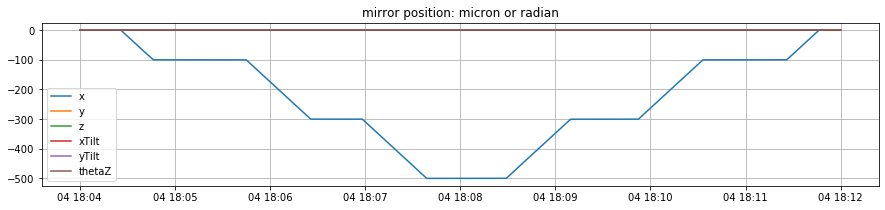

In [5]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xPosition, label='x')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yPosition, label='y')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.piston, label='z')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xTilt, label='xTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yTilt, label='yTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.thetaZPosition, label = 'thetaZ')
plt.title('mirror position: micron or radian')
plt.legend(loc='lower left')
plt.grid();

### Are the disp sensor readings making sense?

In [6]:
def insertHPColumns(a, nonHP):
    [n1, n2] = a.shape
    b = np.zeros((n1, n2+6))
    ii = 0
    for i in range(n2+6):
        if i in nonHP:
            b[:,i] = a[:,ii]
            ii += 1
        else:
            b[:,i] = 0
    return b

def readBinary(matFile):
    mat = scipy.io.loadmat(matFile)
    print(mat['data'].dtype.names)
    mdata = mat['data']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    nt = [datetime.strptime(ts[0][0], '%d-%b-%Y %H:%M:%S.%f') for ts in ndata['timestamp']]
    nt = np.array([ti+ timedelta(hours=4, minutes=3, seconds=-5) for ti in nt]) #convert to utc, 4 hours ahead of Rochester
    columns = [n for n, v in ndata.items()]
    nonHP = [i for i in range(78) if i+1 not in ndata['hp'][0,:]]
    nonHPa = [i for i in range(72) if i+1 not in ndata['hp'][0,:]] #a for axial actuator only
    
    ndata['f_hp'] = insertHPColumns(ndata['f_hp'], nonHP)
    ndata['f_error'] = insertHPColumns(ndata['f_error'], nonHP)

    return ndata, nt, columns, nonHP, nonHPa

ndata, nt, columns, nonHP, nonHPa = readBinary('mat/0304/CellTelemetry_2020-03-04_161146_002.mat')

('time_delta', 'comm_cntr', 'ilc_status', 'encoder', 'force', 'disp_sensors', 'temp_sensors', 'inclinometer', 'step_cmd', 'inc_cal', 'elevation_ts_i', 'elevation_ts_u', 'elevation_ang', 'el_status', 'disp_proc', 'disp_status', 'temp_proc', 'temp_status', 'hp', 'f_e', 'f_0', 'f_a', 'f_f', 'T_u', 'T_x', 'T_y', 'T_r', 'f_hp', 'f_cmd', 'f_error', 'f_delta', 'f_cmd_wrd', 'mtr_voltage', 'comm_voltage', 'mtr_current', 'comm_current', 'dig_input', 'dig_output', 'mtr_voltage_proc', 'comm_voltage_proc', 'mtr_current_proc', 'comm_current_proc', 'time', 'timestamp')


In [7]:
#This starting time is now consistent with binary file name as well
nt[0]

datetime.datetime(2020, 3, 4, 17, 51, 47, 411000)

In [8]:
# cut out only the time period we are interested in
idx = (nt>start) & (nt<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = nt[idx]

0, max = 0.00, min = -0.25
2, max = 0.25, min = 0.00
4, max = 0.00, min = -0.25
6, max = 0.00, min = -0.51
8, max = 0.51, min = 0.00
10, max = 0.28, min = -0.01


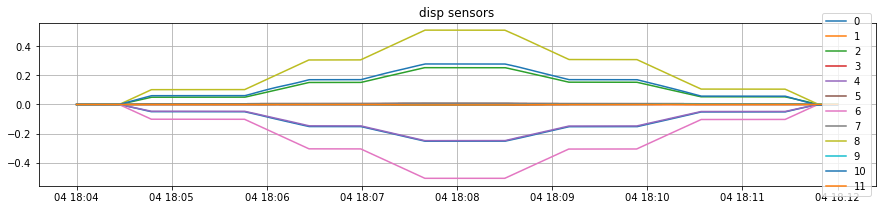

In [9]:
fig, ax = plt.subplots(figsize=(15,3))
nsensor = data['disp_proc'].shape[1]
for i in range(nsensor):
    aa = data['disp_proc'][:,i]-data['disp_proc'][0,i]
    plt.plot(t, aa,'-', label='%d'%i)
    if max(abs(aa))>0.1:
        print('%d, max = %.2f, min = %.2f'%(i,max(aa), min(aa)))
plt.title('disp sensors')
plt.legend(loc='right')
#plt.ylim([14,18])
plt.grid()

* draw a hexagon, each side has an arrowhead pointing clockwise. The direction of the arrows indicate positive change of disp sensor reading. See dispDrawing.pdf. A positive z-rotation in M2 CS makes the 6 disp sensors that are in the x-y plane shorter.
* It is pretty clear that out of the 12 numbers, 1,3,5,7,9,11 are deltaZ, which are in z-direction. So 0,2,4,6,8,10 are in the x/y plane.
* we don't know which way is positive z yet. (from dispDrawing.pdf, 1,3,5,7,9,11 push toward -z in M2 CS)
* with x motion, all 6 sensor readings change. So y axis goes through two tangent links. x-axis is parallel to those two tangent links. It cannot be the other way around. 
* x and y axes do not have arrowheads yet. But we can actually draw y-axis going up - this makes the tangent link at positive y go to the right. If it is not case, we can rotate everything around y for 180 degrees. Then it will be true. This is because we haven't fix positive x or z yet.
* 6 and 8 change the most, which doubles 0,2,4,10. So 6 and 8 are top and bottom.
* 0,4,6 have same sign as x. 2,8,10 have opposite sign. If above x-axis is one group, below x-axis is one group, 0,4,6 are in one group.
* Now there are still two scenarios:
    * 6 is at top (positive y), 8 is at bottom
    * 8 is at top (positive y), 6 is at bottom

In [10]:
#get data ready for later test
aa = data['disp_proc'][:,8]
idx = np.argmax(aa == max(aa))
disp_nx_500 = data['disp_proc'][idx,:] - data['disp_proc'][0,:]

In [11]:
#Te-Wei needs these offset values for implementing the position calculations in actual software.
offset1 = data['disp_proc'][0,:]

### Multiple positions for +y
The start and end time below are obtained by looking at the corresponding plots in a19_position_repeatability.ipynb

In [12]:
start = Time('2020-03-04T18:12:00') #this is UTC
end = Time('2020-03-04T18:17:00') 

In [13]:
df = await client.select_time_series('lsst.sal.MTM2.mirrorPositionMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

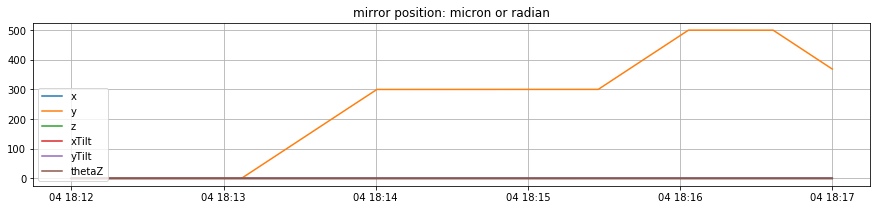

In [14]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xPosition, label='x')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yPosition, label='y')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.piston, label='z')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xTilt, label='xTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yTilt, label='yTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.thetaZPosition, label = 'thetaZ')
plt.title('mirror position: micron or radian')
plt.legend(loc='lower left')
plt.grid();

In [15]:
# cut out only the time period we are interested in
idx = (nt>start) & (nt<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = nt[idx]

0, max = 0.00, min = -0.44
2, max = 0.00, min = -0.45
4, max = 0.44, min = -0.00
10, max = 0.45, min = 0.00


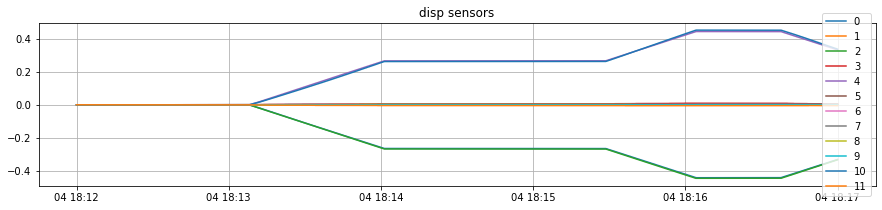

In [16]:
fig, ax = plt.subplots(figsize=(15,3))
nsensor = data['disp_proc'].shape[1]
for i in range(nsensor):
    aa = data['disp_proc'][:,i]-data['disp_proc'][0,i]
    plt.plot(t, aa,'-', label='%d'%i)
    if max(abs(aa))>0.1:
        print('%d, max = %.2f, min = %.2f'%(i,max(aa), min(aa)))
plt.title('disp sensors')
plt.legend(loc='right')
#plt.ylim([14,18])
plt.grid()

* 0 and 2 go opposite of y-axis
* 4 and 10 go the same direction of y-axis
* The two scenarios above both can work. But now for each of those, we can write down numbers (0,2,4,6,8,10) for all sensors.
* we will need more measurements (below) to confirm one and prove the other wrong.

In [17]:
#get data ready for later test
aa = data['disp_proc'][:,4]
idx = np.argmax(aa == max(aa))
disp_py_500 = data['disp_proc'][idx,:] - data['disp_proc'][0,:]

In [18]:
#Te-Wei needs these offset values for implementing the position calculations in actual software.
offset2 = data['disp_proc'][0,:]
print(offset1)
print(offset1-offset2)

[15.52649975 15.68700027 14.81950092 16.98999977 14.42700005 16.70249939
 14.98049927 16.88599968 14.74900055 17.68849945 14.88899994 16.52099991]
[ 0.0009985   0.00050068 -0.00299835 -0.00100136  0.         -0.00100136
  0.00249863  0.00150108 -0.00399971 -0.00200081  0.00500011 -0.00050163]


### Multiple positions for +z,
The start and end time below are obtained by looking at the corresponding plots in a19_position_repeatability.ipynb

In [19]:
start = Time('2020-03-04T18:24:00') #this is UTC
end = Time('2020-03-04T18:30:00') 
df = await client.select_time_series('lsst.sal.MTM2.mirrorPositionMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

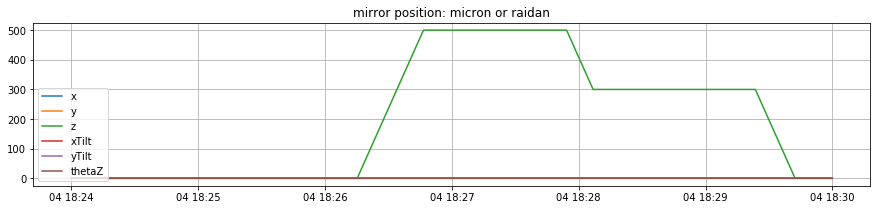

In [20]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xPosition, label='x')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yPosition, label='y')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.piston, label='z')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xTilt, label='xTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yTilt, label='yTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.thetaZPosition, label = 'thetaZ')
plt.title('mirror position: micron or raidan')
plt.legend(loc='lower left')
plt.grid();

In [21]:
# cut out only the time period we are interested in
idx = (nt>start) & (nt<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = nt[idx]

1, max = 0.50
3, max = 0.50
5, max = 0.50
7, max = 0.50
9, max = 0.50
11, max = 0.50


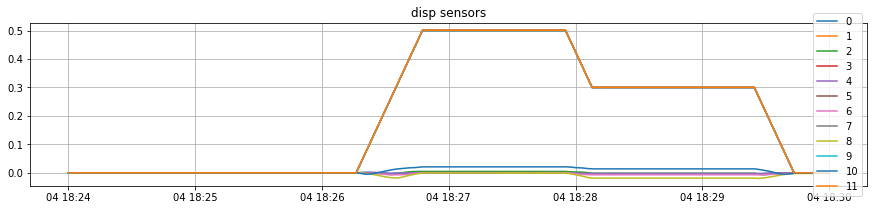

In [22]:
fig, ax = plt.subplots(figsize=(15,3))
nsensor = data['disp_proc'].shape[1]
for i in range(nsensor):
    aa = data['disp_proc'][:,i]-data['disp_proc'][0,i]
    plt.plot(t, aa,'-', label='%d'%i)
    if max((aa))>0.1:
        print('%d, max = %.2f'%(i,max(abs(aa))))
plt.title('disp sensors')
plt.legend(loc='right')
#plt.ylim([14,18])
plt.grid()

* so deltaZ is same direction of the z-axis. All deltaZ sensors are identical. Great.
* but we don't know if the positive deltaZ readings go into the paper or out of the paper.

In [23]:
#get data ready for later test
aa = data['disp_proc'][:,1]
idx = np.argmax(aa == max(aa))
disp_pz_500 = data['disp_proc'][idx,:] - data['disp_proc'][0,:]

In [24]:
#Te-Wei needs these offset values for implementing the position calculations in actual software.
offset3 = data['disp_proc'][0,:]
print(offset1-offset3)

[ 0.00049973  0.         -0.00149918 -0.00150108  0.00250053  0.
  0.00199986  0.         -0.00099945 -0.00050163  0.00899982  0.00099945]


### x-tilt

In [25]:
#x tilt
start = Time('2020-03-04T18:34:00') #this is UTC
end = Time('2020-03-04T19:10:00') 

In [26]:
df = await client.select_time_series('lsst.sal.MTM2.mirrorPositionMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

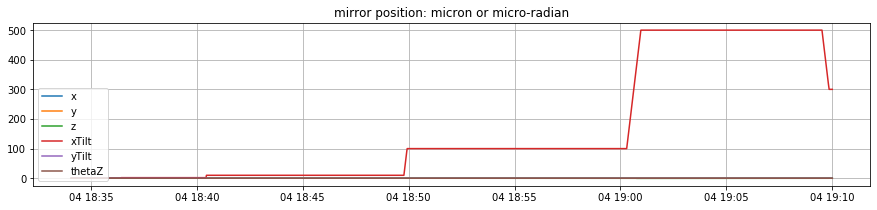

In [27]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xPosition, label='x')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yPosition, label='y')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.piston, label='z')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xTilt*1e6, label='xTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yTilt*1e6, label='yTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.thetaZPosition*1e6, label = 'thetaZ')
plt.title('mirror position: micron or micro-radian')
plt.legend(loc='lower left')
plt.grid();

In [28]:
ndata, nt, columns, nonHP, nonHPa = readBinary('mat/0304/CellTelemetry_2020-03-04_161146_003.mat')

('time_delta', 'comm_cntr', 'ilc_status', 'encoder', 'force', 'disp_sensors', 'temp_sensors', 'inclinometer', 'step_cmd', 'inc_cal', 'elevation_ts_i', 'elevation_ts_u', 'elevation_ang', 'el_status', 'disp_proc', 'disp_status', 'temp_proc', 'temp_status', 'hp', 'f_e', 'f_0', 'f_a', 'f_f', 'T_u', 'T_x', 'T_y', 'T_r', 'f_hp', 'f_cmd', 'f_error', 'f_delta', 'f_cmd_wrd', 'mtr_voltage', 'comm_voltage', 'mtr_current', 'comm_current', 'dig_input', 'dig_output', 'mtr_voltage_proc', 'comm_voltage_proc', 'mtr_current_proc', 'comm_current_proc', 'time', 'timestamp')


In [29]:
nt[0]

datetime.datetime(2020, 3, 4, 18, 41, 47, 411000)

In [30]:
nn = len(nt)
print('%d, time duration = %.0f minutes'%(nn, nn/20/60))

59683, time duration = 50 minutes


In [31]:
# cut out only the time period we are interested in
idx = (nt>start) & (nt<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = nt[idx]
#warning is ok. see https://github.com/LSSTDESC/Monitor/issues/41

0, max = 0.00, min = -0.44
2, max = 0.43, min = -0.00
4, max = 0.00, min = -0.43
6, max = 0.00, min = -0.88
8, max = 0.87, min = -0.00
10, max = 0.44, min = 0.00


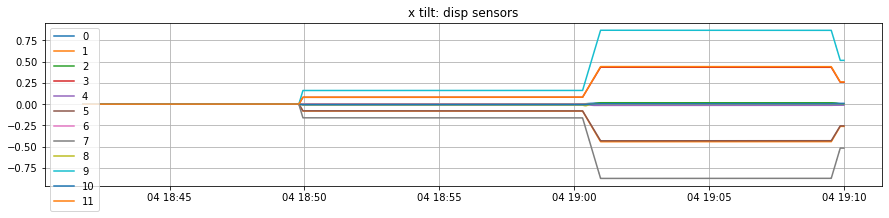

In [32]:
fig, ax = plt.subplots(figsize=(15,3))
nsensor = data['disp_proc'].shape[1]
for i in range(nsensor):
    aa = data['disp_proc'][:,i]-data['disp_proc'][0,i]
    plt.plot(t, aa,'-', label='%d'%i)
    if max(abs(aa))>0.1:
        print('%d, max = %.2f, min = %.2f'%(i-1,max(aa), min(aa)))
plt.title('x tilt: disp sensors')
plt.legend(loc='upper left')
#plt.ylim([14,18])
plt.grid()

* positive 0,4,6 contribute to negative x-tilt - so this excludes the scenario where 6 is at positive y, where z comes out of the paper.
## So now we know the sensor positions relative to the x,y,z axes.
    * all thetaZ sensor positives go clockwise.
    * all deltaZ sensor positives go into the paper.
    * x axis points left
    * y axis points up
    * z axis points into the paper (yes this seems to be left-handed, but see data on Rz below)
    * 8 is at positive y.
    * clockwise, we have 8,2,0,6,4,10 (not sure why it is in this order)
### When we go back to the summit, we should disconnect each sensor and figure out their physical loccation. Then we can map out the coordinate system on the hardware.

In [33]:
#get data ready for later test
aa = data['disp_proc'][:,9]
idx = np.argmax(aa == max(aa))
disp_prx_500 = data['disp_proc'][idx,:] - data['disp_proc'][0,:] #unit is micro-radian

In [34]:
#Te-Wei needs these offset values for implementing the position calculations in actual software.
offset4 = data['disp_proc'][0,:]
print(offset1-offset4)

[ 0.00149918  0.00899982 -0.00149918 -0.01000023  0.00199986  0.00849915
  0.00299835  0.01849937  0.00050163 -0.01799965  0.0094986  -0.00799942]


### y-tilt

In [35]:
#y tilt
start = Time('2020-03-04T19:16:00') #this is UTC
end = Time('2020-03-04T19:20:00') 

In [36]:
df = await client.select_time_series('lsst.sal.MTM2.mirrorPositionMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

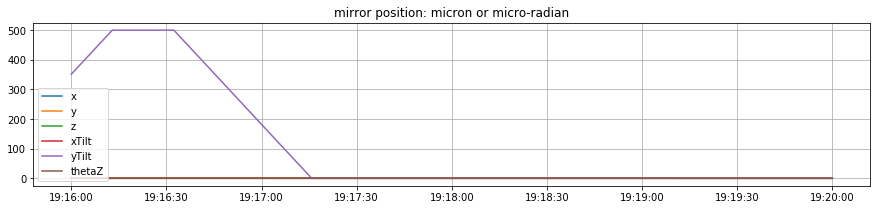

In [37]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xPosition, label='x')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yPosition, label='y')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.piston, label='z')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xTilt*1e6, label='xTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yTilt*1e6, label='yTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.thetaZPosition*1e6, label = 'thetaZ')
plt.title('mirror position: micron or micro-radian')
plt.legend(loc='lower left')
plt.grid();

In [38]:
# cut out only the time period we are interested in
idx = (nt>start) & (nt<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = nt[idx]

0, max = 0.77, min = 0.00
2, max = 0.79, min = -0.00
4, max = 0.00, min = -0.77
10, max = 0.00, min = -0.77


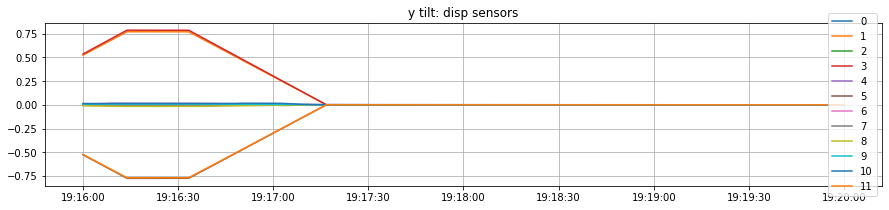

In [39]:
fig, ax = plt.subplots(figsize=(15,3))
nsensor = data['disp_proc'].shape[1]
for i in range(nsensor):
    aa = data['disp_proc'][:,i]-data['disp_proc'][-1,i]
    plt.plot(t, aa,'-', label='%d'%i)
    if max(abs(aa))>0.1:
        print('%d, max = %.2f, min = %.2f'%(i-1,max(aa), min(aa)))
plt.title('y tilt: disp sensors')
plt.legend(loc='right')
#plt.ylim([14,18])
plt.grid()

* positive 0 and 2 contribute to positive y-tilt
* this agrees with our drawing above

In [40]:
#get data ready for later test
aa = data['disp_proc'][:,1]
idx = np.argmax(aa == max(aa))
disp_pry_500 = data['disp_proc'][idx,:] - data['disp_proc'][-1,:]

In [41]:
#Te-Wei needs these offset values for implementing the position calculations in actual software.
offset5 = data['disp_proc'][0,:]
print(offset1-offset5)

[ 0.         -0.52250099  0.00199986 -0.53450012 -0.00450134  0.52699852
 -0.00600052  0.00649834  0.01349926 -0.00349998 -0.00450134  0.52499962]


### z-rotation

In [42]:
#z rotation
start = Time('2020-03-04T20:02:00') #this is UTC
end = Time('2020-03-04T20:15:00') 

In [43]:
df = await client.select_time_series('lsst.sal.MTM2.mirrorPositionMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)

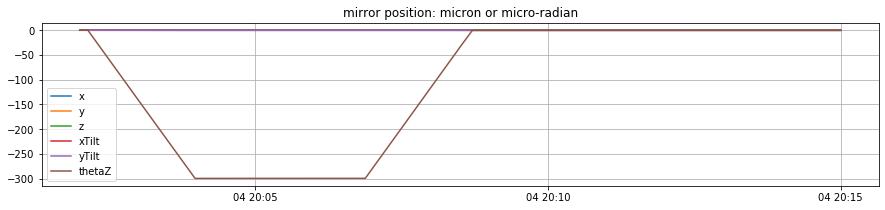

In [44]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xPosition, label='x')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yPosition, label='y')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.piston, label='z')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.xTilt*1e6, label='xTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.yTilt*1e6, label='yTilt')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.thetaZPosition*1e6, label = 'thetaZ')
plt.title('mirror position: micron or micro-radian')
plt.legend(loc='lower left')
plt.grid();

In [45]:
ndata, nt, columns, nonHP, nonHPa = readBinary('mat/0304/CellTelemetry_2020-03-04_194105_000.mat')

('time_delta', 'comm_cntr', 'ilc_status', 'encoder', 'force', 'disp_sensors', 'temp_sensors', 'inclinometer', 'step_cmd', 'inc_cal', 'elevation_ts_i', 'elevation_ts_u', 'elevation_ang', 'el_status', 'disp_proc', 'disp_status', 'temp_proc', 'temp_status', 'hp', 'f_e', 'f_0', 'f_a', 'f_f', 'T_u', 'T_x', 'T_y', 'T_r', 'f_hp', 'f_cmd', 'f_error', 'f_delta', 'f_cmd_wrd', 'mtr_voltage', 'comm_voltage', 'mtr_current', 'comm_current', 'dig_input', 'dig_output', 'mtr_voltage_proc', 'comm_voltage_proc', 'mtr_current_proc', 'comm_current_proc', 'time', 'timestamp')


In [46]:
nt[0]

datetime.datetime(2020, 3, 4, 19, 41, 5, 961000)

In [47]:
nn = len(nt)
print('%d, time duration = %.0f minutes'%(nn, nn/20/60))

59999, time duration = 50 minutes


In [48]:
# cut out only the time period we are interested in
idx = (nt>start) & (nt<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = nt[idx]

0, max = 0.00, min = -0.54
2, max = 0.00, min = -0.55
4, max = 0.00, min = -0.54
6, max = 0.00, min = -0.54
8, max = 0.00, min = -0.55
10, max = 0.00, min = -0.55


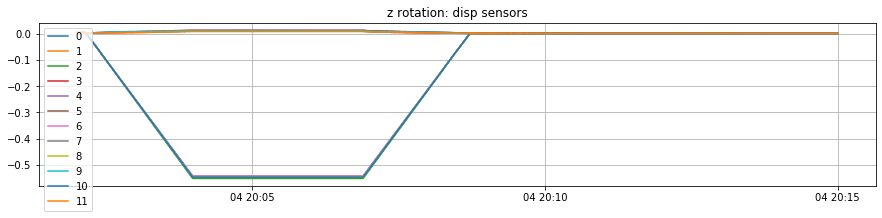

In [49]:
fig, ax = plt.subplots(figsize=(15,3))
nsensor = data['disp_proc'].shape[1]
for i in range(nsensor):
    aa = data['disp_proc'][:,i]-data['disp_proc'][-1,i]
    plt.plot(t, aa,'-', label='%d'%i)
    if max(abs(aa))>0.1:
        print('%d, max = %.2f, min = %.2f'%(i,max(aa), min(aa)))
plt.title('z rotation: disp sensors')
plt.legend(loc='upper left')
#plt.ylim([14,18])
plt.grid()

* negative deltaZ contributes to negative z
* this agrees with our drawing above

In [50]:
#get data ready for later test
aa = data['disp_proc'][:,8]
idx = np.argmax(aa == min(aa))
disp_nrz_300 = data['disp_proc'][idx,:] - data['disp_proc'][-1,:]

In [51]:
#Te-Wei needs these offset values for implementing the position calculations in actual software.
offset6 = data['disp_proc'][0,:]
print(offset1-offset6)

[ 0.00349998  0.          0.00250053  0.00049973  0.00149918 -0.00050163
  0.00549889  0.00150108  0.00250149  0.00200081  0.00799942  0.00250053]


For now, ignore the how to scale the sensor reading to real sensor length.

In [52]:
c30 = np.cos(30/180*np.pi)
dof2disp = np.array([[ 0.5, 0, -0.5, 0, 0.5, 0, 1, 0, -1, 0, -0.5, 0],#column 1, for x
                            [-c30, 0, -c30, 0, c30, 0, 0, 0, 0,  0, c30, 0],#column 2, for y
                            [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], #column 3, for z
                            [0, -0.5, 0, 0.5, 0, -0.5, 0, -1, 0, 1, 0, 0.5], #for x-tilt, 
                            [0, c30,0, c30, 0, -c30, 0, 0, 0, 0, 0, -c30],#for y-tilt
                            [1, 0, 1, 0, 1, 0 ,1, 0, 1, 0, 1, 0]] #for z-rotation, 
                           ).transpose()
np.set_printoptions(precision=2, suppress=True)
print(dof2disp)
# disp = AA * dof, where dof is a 6x1 vector containing x,y,z,rx,ry,rz
#.   disp is a 12x1 vector, containing the delta L of the 12 disp sensors.
#makes sense, for example, delta X = 1 would cause 0,2,4,6,8,10 to move by 1 or 0.5
#note that it is not going to be 1 or 2. 
#if you hang a rod from the ceiling, and it is 30 deg from vertical, and pull it further away from vertical,
# this motion is decomposed into a lengthening motion and a rotation around the pivot.

[[ 0.5  -0.87  0.    0.    0.    1.  ]
 [ 0.    0.    1.   -0.5   0.87  0.  ]
 [-0.5  -0.87  0.    0.    0.    1.  ]
 [ 0.    0.    1.    0.5   0.87  0.  ]
 [ 0.5   0.87  0.    0.    0.    1.  ]
 [ 0.    0.    1.   -0.5  -0.87  0.  ]
 [ 1.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    1.   -1.    0.    0.  ]
 [-1.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    1.    1.    0.    0.  ]
 [-0.5   0.87  0.    0.    0.    1.  ]
 [ 0.    0.    1.    0.5  -0.87  0.  ]]


In [53]:
thetaz_scaling = 0.50/500 #0.51 above corresponds to 500um #we assume the 0.51 is in mm, 0.5mm = 500um
deltaz_scaling = thetaz_scaling #they should be same if they are same kind of sensors
R_M2 = np.sqrt(1781.04**2+9.52**2)*1e-3 #using R1 location from Neill Mills. Z1 is a tiny bit different.
tilt_scaling = (1/3600/180*np.pi*R_M2*1e6)*deltaz_scaling #we use arcsec for tilt angle. This converts it into um at a distance of R_M2

dof2disp[:,:3] = dof2disp[:,:3]*thetaz_scaling 
dof2disp[:,3:] = dof2disp[:,3:]*tilt_scaling 

disp2dof = np.linalg.pinv(dof2disp)

In [54]:
aa = (1/3600/180*np.pi)*1e6
as2urad = np.array([1,1,1,aa,aa,aa])
pos_nx_500 = np.matmul(disp2dof, disp_nx_500)*as2urad
pos_py_500 = np.matmul(disp2dof, disp_py_500)*as2urad
pos_pz_500 = np.matmul(disp2dof, disp_pz_500)*as2urad
pos_prx_500 = np.matmul(disp2dof, disp_prx_500)*as2urad
pos_pry_500 = np.matmul(disp2dof, disp_pry_500)*as2urad
pos_nrz_300 = np.matmul(disp2dof, disp_nrz_300)*as2urad

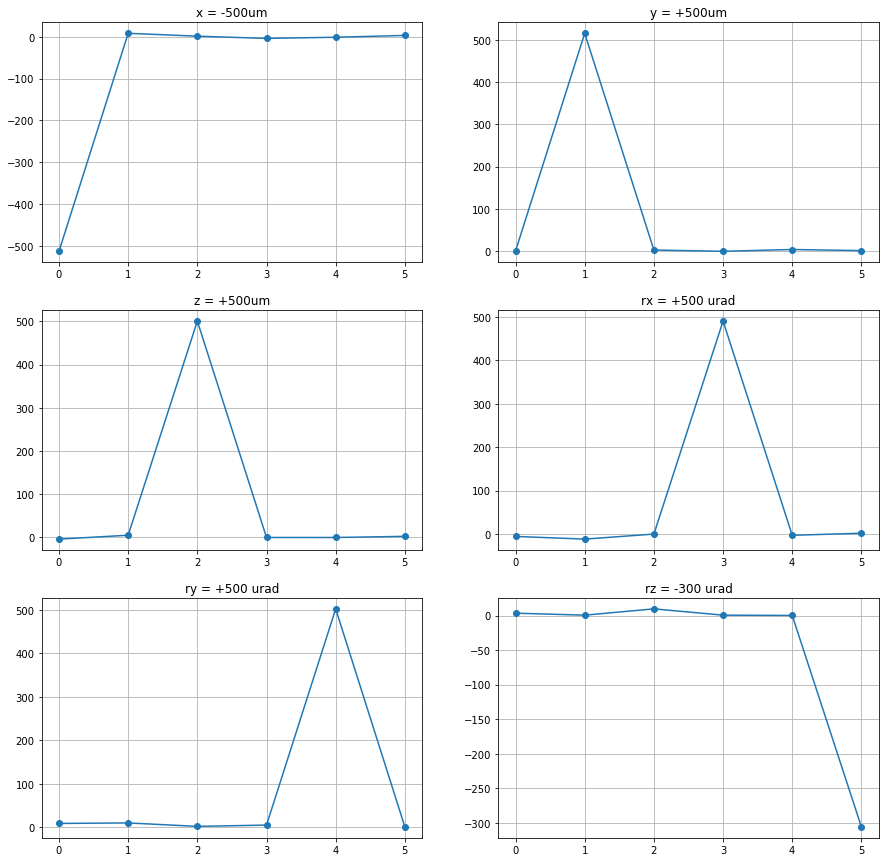

In [55]:
fig, ax = plt.subplots(3,2, figsize=(15,15))
ax[0][0].plot(pos_nx_500,'-o')
ax[0][0].set_title('x = -500um')
ax[0][0].grid()
ax[0][1].plot(pos_py_500,'-o')
ax[0][1].set_title('y = +500um')
ax[0][1].grid()
ax[1][0].plot(pos_pz_500,'-o')
ax[1][0].set_title('z = +500um')
ax[1][0].grid()
ax[1][1].plot(pos_prx_500,'-o')
ax[1][1].set_title('rx = +500 urad')
ax[1][1].grid()
ax[2][0].plot(pos_pry_500,'-o')
ax[2][0].set_title('ry = +500 urad')
ax[2][0].grid()
ax[2][1].plot(pos_nrz_300,'-o')
ax[2][1].set_title('rz = -300 urad')
ax[2][1].grid()

In [56]:
np.savetxt('disp2dof.txt', disp2dof, fmt = ' '.join(['%8.3f' for i in range(12)]), 
           header = 
           '6x12 matrx \n multipling with 12x1 vector read from disp sensors gives x,y,z in um and rx,ry,rz in arcsec\
           \n Disp sensor readings need to have offsets subtracted' )

In [57]:
np.savetxt('dispOffsets.txt', offset1, fmt = '%8.3f',
          header = 'offset positions for IMS sensors. Unit is the same as in the binary output files.')